# Automatic Licence Plate Recognition

For my senior project, I joined a team tasked to design an automatic licence plate reading system.  We decided to use python and various machine learning libraries to accomplish this task.  There was a lot of initial research, and many different prototypes, but now we can boil down what we have into a short post like this.

We will go through the whole process from raw pictures we took with our phones, to recognized licence plate characters.  Our system segments an image of a licence plate into 6 separate cropped images for each of the characters.  This is repeated many times for each of our licence plate images, and our training/testing set is built out of these cropped licence plate character images.  We then train a Neural Network using the segmented characters.  Once the model is trained, we can use it to predict future licence plate images.  We feed the system an image of a licence plate and it predicts the characters that are on it.

##### In this post we will:
* pre-process an image of a licence plate
* run our automatic character segmentation algorithm
* label data
* prepare data for use in neural network
* train and test our neural network

##### In future posts we will:
* Artificially expand our data
* Link trained neural network with new licence plates for quick classification.
* Use convolutional neural networks to detect state, and to detect if there is a licence plate in an image




### Lets get started by running our character segmentation on a test image.

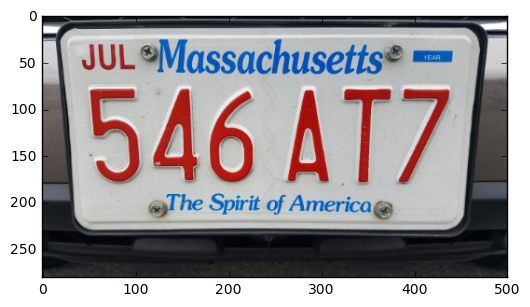

In [62]:
#we need to import mpimg for reading and writing image files
import matplotlib.image as mpimg

pic = mpimg.imread('demo_lp/demo.jpg')

#we'll import pyplot to view our images
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(pic)

## Image Pre-processing
In order for our character segmentation algorithm to work, we need to do some initial processing on each image.  We convert it from RGB to gray, then we reduce the resolution of the image to make the computation easier.  Then we convert the image to black and white based on a thresholded percent of the maximum brightness.

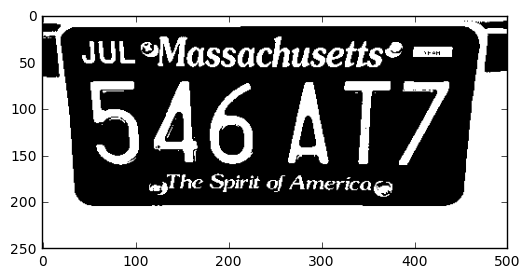

In [63]:
#we'll import our filters module which has some functions we want to use
import filters

#we'll convert our image to grayscale because we don't use color information to segment the image
graypic = filters.rgb2gray(pic)

#we'll import scipy to resize the image
import scipy.misc

#first we'll scale down our image, we don't need all the resolution, so scaling saves us time later.
smallpic = scipy.misc.imresize(graypic, (250,500))

#before we run our segmentation algorithm we want to threshold the image to black/white values
inverted_image = filters.invert2BnW(smallpic, 0.5)

plt.imshow(inverted_image, 'gray')

## Character Segmentation
Now that our image is treated, we'll import the rectfinder library we created.  We'll use the Tracer object to find the rectangles.  The tracer is initialized with 3 parameters, minimum rectangle area, maximum rectangle area, and maximum rectangle width (all as percentages of the image size.)  By setting these in the right way, we can easily and automatically extract the smaller character images from the larger licence plate image.

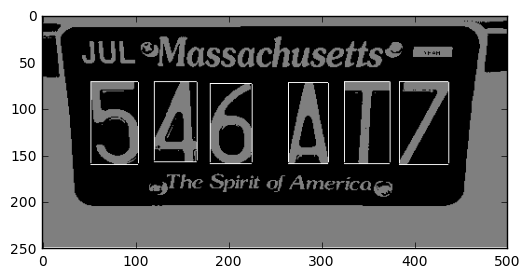

In [64]:
#we need to import our rectfinder module
import rectfinder

#now we can segment the image
rectangles = rectfinder.Tracer(inverted_image, 0.02, 0.15, 0.1)

plt.imshow(rectangles.highlight_rects(), 'gray')

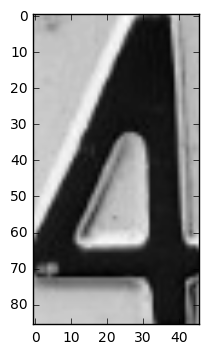

In [65]:
#now we'll extract the rects and store them in a list
rects = rectangles.extract_rects(smallpic)
images = [r for r in rects]

plt.imshow(images[1], 'gray')

## Labeling Data
Now that we have a way to automatically segment the individual characters, we need to label each one for use in our neural network.  By labeling the type of character we are able to feed our network each image with the character value.  This allows the network to learn about each character and what an image of that character looks like.  We want to label a large amount of data so the network will be able to predict new licence plate characters with high accuracy.  The more data we can label right now, the better.


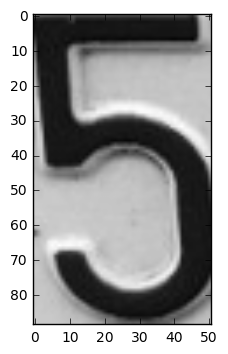

Enter class: 5


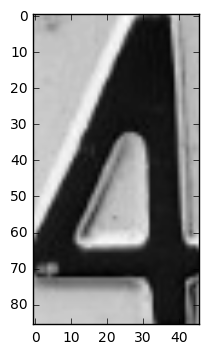

Enter class: 4


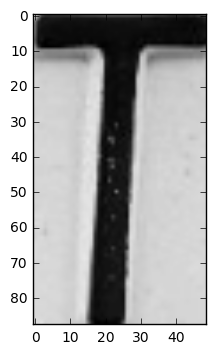

Enter class: t


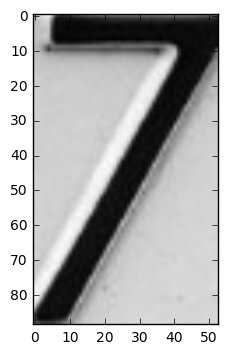

Enter class: 7


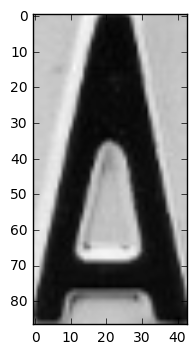

Enter class: a


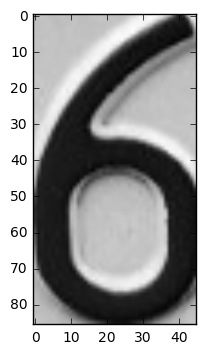

Enter class: 6


In [66]:
labelled_images = []  # list of images that have been labelled
classifiers = []      # list of training data classifiers

# get classifiers for each rectangle
# '-' will ignore rectangle
for i in images:
    filters.draw(i)
    classifier = str.capitalize(str(input("Enter class: ")))
    if (len(classifier) == 1 and (str.isalpha(classifier) or str.isdigit(classifier))):
        labelled_images.append(i)
        classifiers.append(classifier)

We will get a display of each image and a prompt asking us to label it.  This took quite a long time to label our entire dataset of 350 licence plates.  But in the end it is necessary to have labelled data if we want to train a neural network.

We stored the character images as grayscale because the rgb information is not necessary. Licence plate characters are well defined; a neural network will have plenty of information because it can see the clear boundaries of the character.  Color is extra information that complicates the model.

## Preparing our images for training
We have all of our images from running the character segmentation over our 350 licence plates.  Now we need to read them in and do some pre-processing on them to get them ready to pass into our neural network.  

The preprocessing that we'll do includes:
* resizing the image to a uniform 28x28
* reshaping the image to a 1-dimensional form
* normalizing image data between 0-1
* converting int classifier into a vector

In [67]:
#we'll import pandas to easilly read from our classifiers csv file
import pandas as pd

#we'll import numpy for some easy array manipulation
import numpy as np

#get classifiers file to figure out number of images, and classifier of each image
classifiers = pd.read_csv("images/classifiers.txt", names = ['classes'], squeeze = True)

data = []

#loop through classifiers list so we can load each image and link it with its classifier
for (i,c) in enumerate(classifiers):

    #read an image using the index of the classifier as part of the name of the image file
    temp_img = mpimg.imread("images/lp"+str(i)+".png")

    #scale the image to our uniform 28x28 size
    temp_img = scipy.misc.imresize(temp_img, (28,28))

    #convert to 1d to so we can pass it as input into the NN
    temp_img = np.reshape(temp_img, (28*28))
    
    #normalize image data
    temp_min = np.min(temp_img)
    temp_max = np.max(temp_img)
    temp_img = [((x - temp_min) / (temp_max - temp_min)) for x in temp_img]

    #convert classifier into a vector to be compared to output of NN
    class_vector = np.zeros([36])
    for j in range(36):
        if(j == classifiers[i]):
            class_vector[j] = 1

    #bundle image and classifier into one instance to be put into a list
    data_instance = [temp_img,class_vector]
    
    #append data_instance into our list
    data.append(data_instance)
    
np.shape(data)

(1786, 2)

Now we have a list of all of our pre-processed images next to their classifiers.  We're going to want to split the training and testing data into training and testing, but we'll have to shuffle them first.  We'll do a 80/20 train/test split.

In [68]:
#we'll import random for shuffling the data
import random

#lets seed random and numpy with a predetermined seed to have repeatable results
seed = 5
random.seed(seed)
np.random.seed(seed)

#use l as the index of 80% through the list
l = int(len(data) * (0.80))
    
#shuffle the data
random.shuffle(data)

#split training and testing data using index of 80%
training_data = data[:l]
testing_data = data[l:]

Now that we have our training and testing data, we need to separate the images and classifiers to pass into the neural network.  We'll also convert everything into numpy arrays, figure out the size of inputs, and the number of classes.

In [69]:
#Split data into X (images) and y (classifiers)
X_train, y_train = zip(*training_data)
X_test, y_test = zip(*testing_data)

#count number of pixels in image
num_pixels = len(X_train[0])

#count number of possible classes in classifier
num_classes = len(y_train[0])

#convert all data to numpy arrays to be used by the neural network
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

## Training the network
We're ready to start training the neural network, so lets import our libraries and start configuring the architecture of the model.  We'll use MLPClassifier from the sci-kit learn library to easily create our network.  Most of the defaults for the MLPClassifier are very good, so we just change a few things.  We want to have a high number of hidden_neurons so we have the ability to learn all the complexities of our 36 different classes.  And we want to have a high number of epochs to make sure we train for long enough to get a good classification accuracy. 

With 500 epochs this will take a long time to train (about 10-15 minutes) but we don't care about how long it takes.  We could spend days training if we really wanted to.  Whatever gets us a better model for predicting future licence plates.  We fit the model with our image and classifier from the training data.

Then we have a simple bit of code to calculate the accuracy of the network on the testing data.

In [71]:
#function to convert a vector to an integer
def v2i(vector):
    for (c,i) in enumerate(vector):
        if(i == 1):
            return c
    return -1

#import multi layer perceptron classifier from scikit learn
from sklearn.neural_network import MLPClassifier

#number of hidden neurons in the middle layer
hidden_neurons = 750

#maximum number of times to loop through the training data
epochs = 500

#create the model, most of the default parameters are good for our problem
#we'll just set the maximum iterations and a random state for repeatability
model = MLPClassifier(hidden_layer_sizes = (hidden_neurons,),
                      max_iter=epochs, random_state = 1, tol = 0)

#start training the model
model.fit(X_train, y_train)

#predict test set
predictions = model.predict(X_test)



#check percetage correct and store incorrect images in a list to display
num_correct = 0
num_incorrect = 0
max_incorrect = 4
incorrect_images = []
incorrect_classifiers = []
for (i,p) in enumerate(predictions):
    if(v2i(p) == v2i(y_test[i])):
        num_correct += 1
    elif(num_incorrect < max_incorrect):    
        num_incorrect += 1
        incorrect_images.append(np.reshape(X_test[i],(28,28)))
        incorrect_classifiers.append("Predicted: "+str(v2i(p)) + " / Actual: " + str(v2i(y_test[i])))
                                
        
    
#print accuracy of classification on test set    
accuracy = num_correct/len(predictions)
print("Accuracy: %.4f%%\n" % (accuracy*100))    

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Accuracy: 98.6034%



These are very good results, lets look at some of the images that the network couldn't classify.

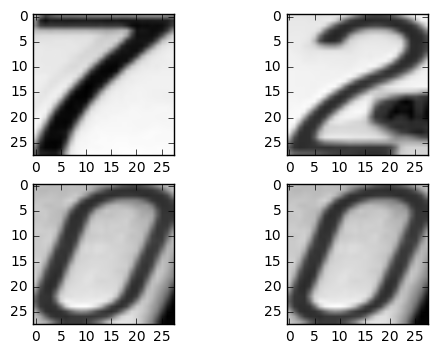

In [97]:
#display images and predicitons of incorrect classifications
plt.subplot(2,2,1)
plt.imshow(incorrect_images[0], 'gray')
plt.subplot(2,2,2)
plt.imshow(incorrect_images[1], 'gray')
plt.subplot(2,2,3)
plt.imshow(incorrect_images[2], 'gray')
plt.subplot(2,2,4)
plt.imshow(incorrect_images[3], 'gray')


plt.show()

The network couldn't make a good enough choice about what class the image belonged to.  It probably means that these images look different than most images in the same class.  One thing that might be causing this is uneven representation of classes in the dataset, lets look at the distribution.

In [82]:
images, classifiers = zip(*data)

int_classes = []
#convert classifiers to integer
for (i,c) in enumerate(classifiers):
    value = v2i(c)
    if(value > 9):
        value = value + 55
        value = chr(value)
    else:
        value = str(value)
    
    int_classes.append(value)
    
#convert to a pandas series to easilly count values
pd.Series(int_classes).value_counts()

5    144
2    139
7    135
4    128
3    127
9    111
8    107
6    101
1     96
0     54
T     41
W     38
M     38
X     37
A     33
C     33
L     32
R     30
Z     30
J     30
F     28
D     28
Y     27
K     27
H     27
G     27
B     26
V     25
P     24
E     24
S     20
N     16
U      2
I      1
dtype: int64

We can see that there is a very uneven distribution of letters here.  There is only 1 'I' so if I is in the testing set, the training set will have 0 'I's in it and the model will learn nothing about 'I' and will be unable to predict it correctly.  It seems that licence plates have a higher probability to have certain characters, especially the numbers.  Ideally we would go and collect more data until we could have an even representation of all characters while having enough data to train the network.  

Since we can't go collect more data right now, we'll duplicate characters until there is an even distribution of each.  This will make sure that we train the network equally with each character.

In [94]:
#check frequencies of each character
frequencies = np.zeros([36])

#create a list of 36 lists
freq_images = [[] for i in range(36)]

#loop through data and create update list of frequencies
for i in data:
    temp_index = v2i(i[1])
    frequencies[temp_index] += 1

    #add image to list with index equal to its classifier
    freq_images[temp_index].append(i)

#find character with the highest frequency
max_freq = np.max(frequencies)

#duplicate images until there is even representaton of each image
for i in range(len(freq_images)):

    for j in range(int(max_freq - len(freq_images[i]))):
        if(len(freq_images[i]) != 0):
            freq_images[i].append(freq_images[i][j])
            
#copy all images into a new list
even_data = []
for i in freq_images:
    for j in i:
        even_data.append(j)
        
images, classifiers = zip(*even_data)

int_classes = []
#convert classifiers to integer
for (i,c) in enumerate(classifiers):
    value = v2i(c)
    if(value > 9):
        value = value + 55
        value = chr(value)
    else:
        value = str(value)
    
    int_classes.append(value)
    
#convert to a pandas series to easilly count values
pd.Series(int_classes).value_counts().head(10)


K    144
3    144
9    144
Z    144
V    144
Y    144
4    144
R    144
T    144
6    144
dtype: int64

We can see that each letter has an even distribution of 144 images.  Some of the images have been copied many times, like "I" and "U" so it's not the ideal scenario, but lets see how the network does now.

In [96]:
#Use l as the index of 80% through the list
l = int(len(even_data) * (0.80))
    
#shuffle the data
random.shuffle(even_data)

#split training and testing data using index of 80%
training_data = even_data[:l]
testing_data = even_data[l:]

X_train, y_train = zip(*training_data)
X_test, y_test = zip(*testing_data)

#count number of pixels in image
num_pixels = len(X_train[0])

#count number of possible classes in classifier
num_classes = len(y_train[0])

#convert all data to numpy arrays to be used by the neural network
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

#number of hidden neurons in the middle layer
hidden_neurons = 750

#maximum number of times to loop through the training data
epochs = 500

#create the model, most of the default parameters are good for our problem
#we'll just set the maximum iterations and a random state for repeatability
model = MLPClassifier(hidden_layer_sizes = (hidden_neurons,),
                      max_iter=epochs, random_state = 1, tol = 0)

#start training the model
model.fit(X_train, y_train)

#predict test set
predictions = model.predict(X_test)

#check percetage correct and store incorrect images in a list to display
num_correct = 0
num_incorrect = 0
max_incorrect = 4
incorrect_images = []
incorrect_classifiers = []
for (i,p) in enumerate(predictions):
    if(v2i(p) == v2i(y_test[i])):
        num_correct += 1
    elif(num_incorrect < max_incorrect):    
        num_incorrect += 1
        incorrect_images.append(np.reshape(X_test[i],(28,28)))
        incorrect_classifiers.append("Predicted: "+str(v2i(p)) + " / Actual: " + str(v2i(y_test[i])))
                                
        
    
#print accuracy of classification on test set    
accuracy = num_correct/len(predictions)
print("Accuracy: %.4f%%\n" % (accuracy*100))    

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Accuracy: 99.3878%



These are great results! We gained almost 1% accuracy from our last model.  It seems that having an even distribution of data helps a lot.  

There are some limitations to this duplication strategy however.  We'll have to test out our model on some brand new images to see how well it generalizes.  Theres a good chance that because it's only trained on a few different "I"s or "U"s it won't have a good idea about new different 'I's and 'U's.  

In our next post we'll explore artificial expansion of the data by using perspective transformations.  This will allow us to create new different data based on our existing data.  This will help us generalize to new licence plates much better.